In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

# Parameters

In [2]:
iteration =2
PhenoGraph_k =  100
node_label = 'CellType'
size_smallest_cluster  = 20
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 95,
    'knn_k': 30
}
patient_filtering_dict = {
    # 'Clinical Subtype': 'HR+/HER2-',
}


# Subset 1

In [3]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

379 patients are included


In [6]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

379 patients are included
S1 (N = 26):
Survival: hr = 2.428013562030345, p = 0.0009529780614233097
	Significant
S2 (N = 48):
Survival: hr = 1.6715184635587368, p = 0.02843447397812587
S3 (N = 23):
Survival: hr = 1.1993259620126575, p = 0.6188721644067485
S4 (N = 73):
Survival: hr = 1.1496241238841327, p = 0.5148989278165488
S5 (N = 61):
Survival: hr = 0.9672335783354061, p = 0.8872245985054152
S6 (N = 51):
Survival: hr = 0.6150989479810047, p = 0.12382629829932304
S7 (N = 97):
Survival: hr = 0.514502885809581, p = 0.005382388188832714
	Significant


#### Paint population graph nodes with clinical subtype labels

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


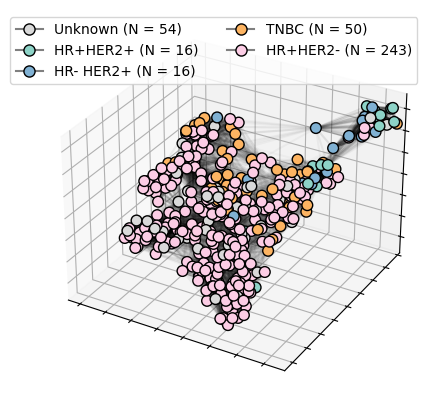

In [5]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    'two_step_knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
Clinical_subtypes_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_])
pos = nx.spring_layout(
    G_population, seed=3, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
)
Clinical_subtype_id = np.array([0] * len(Clinical_subtypes_))
Clinical_subtype_id[Clinical_subtypes_ == "HR+/HER2-"] = 4
Clinical_subtype_id[Clinical_subtypes_ == "HR+/HER2+"] = 1
Clinical_subtype_id[Clinical_subtypes_ == "HR-/HER2+"] = 2
Clinical_subtype_id[Clinical_subtypes_ == "TNBC"] = 3
color_palette = [sns.color_palette("Set3")[8]] + [sns.color_palette("Set3")[0] ] +[sns.color_palette("Set3")[4] ] + [sns.color_palette("Set3")[5] ] + [sns.color_palette("Set3")[7]]

fig = plt.figure(figsize=(5,5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette[int(i)] for i in Clinical_subtype_id],
    # # c= 'white',
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(G_population.edges())
edge_alpha = [
    0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)

handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[0],
        label="Unknown (N = {})".format(np.sum(Clinical_subtype_id == 0)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[1],
        label="HR+HER2+ (N = {})".format(np.sum(Clinical_subtypes_ == "HR+/HER2+")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[2],
        label="HR- HER2+ (N = {})".format(np.sum(Clinical_subtypes_ == "HR-/HER2+")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[3],
        label="TNBC (N = {})".format(np.sum(Clinical_subtypes_ == "TNBC")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
        Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[4],
        label="HR+HER2- (N = {})".format(np.sum(Clinical_subtypes_ == "HR+/HER2-")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),



]
ax.legend(handles=handles, fontsize = 10, ncols = 2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])
plt.show()

In [7]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtypes_ == 'TNBC')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'TNBC')[0].tolist())]
print("{} TNBC patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtypes_ == 'HR+/HER2-')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'HR+/HER2-')[0].tolist())]
print("{} 'HR+/HER2-' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtypes_ == 'HR+/HER2+')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'HR+/HER2+')[0].tolist())]
print("{} 'HR+/HER2+' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtypes_ == 'HR-/HER2+')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'HR-/HER2+')[0].tolist())]
print("{} 'HR-/HER2+' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
print("{} Overall patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

50 TNBC patients, averaged Intra-group similarity is 0.15 
243 'HR+/HER2-' patients, averaged Intra-group similarity is 0.20 
16 'HR+/HER2+' patients, averaged Intra-group similarity is 0.46 
16 'HR-/HER2+' patients, averaged Intra-group similarity is 0.41 
379 Overall patients, averaged Intra-group similarity is 0.18 


### Presentation of 4 clinical subtypes

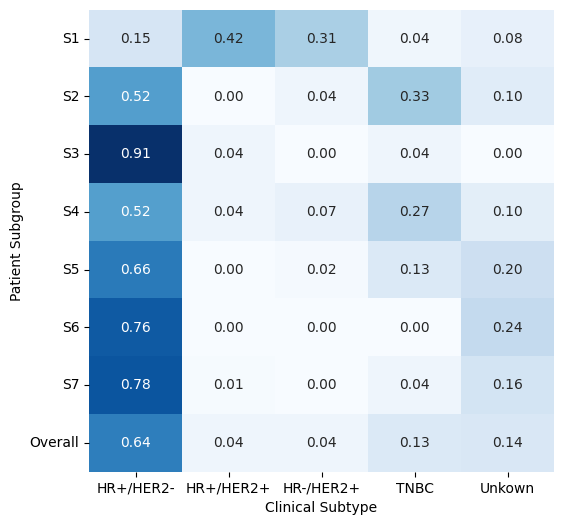

In [8]:
Clinical_subtypes_ = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_]
DF = pd.DataFrame({'subgroup_id' : ['S'+str(int(i)) for i in range(1, int(np.max(Subgroup_ids_))+1)] + ['Overall']})
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"]:
        data = (np.array(Clinical_subtypes_) == clinical_subtype)*(np.array(Subgroup_ids_) == subgroup_id)
        exisitence_ratio = np.sum(data > 0) / np.sum((np.array(Subgroup_ids_) == subgroup_id))
        DF.loc[DF['subgroup_id'] == 'S'+str(int(subgroup_id)), clinical_subtype] = exisitence_ratio
        
for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
    data = (np.array(Clinical_subtypes_) == clinical_subtype)
    exisitence_ratio = np.sum(data > 0) / len(data)
    DF.loc[DF['subgroup_id'] == 'Overall', clinical_subtype] = exisitence_ratio

f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(DF.values[:,1:].astype('float'), ax=ax, cmap="Blues", annot=True, fmt=".2f", cbar = False)
ax.set_xlabel("Clinical Subtype")
ax.set_ylabel("Patient Subgroup")
ax.set_xticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "Unkown"], rotation=0)
ax.set_yticklabels(DF.values[:,0], rotation=0)
plt.show()


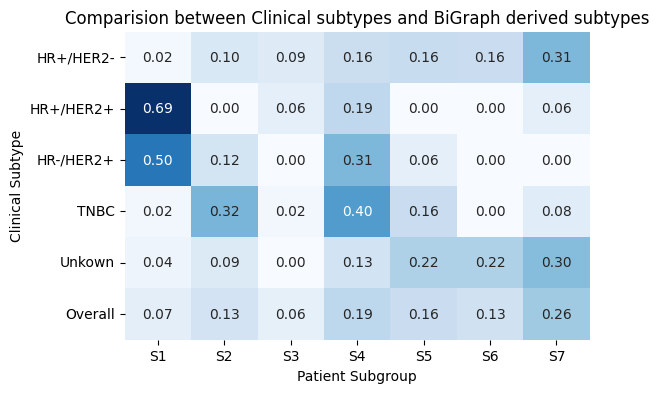

In [9]:
Clinical_subtypes_ = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_]
DF = pd.DataFrame({'clinical_subtype' : ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan', 'Overall']})
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
        data = (np.array(Clinical_subtypes_) == clinical_subtype)*(np.array(Subgroup_ids_) == subgroup_id)
        exisitence_ratio = np.sum(data > 0) / np.sum((np.array(Clinical_subtypes_) == clinical_subtype))
        DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'S'+str(int(subgroup_id))] = exisitence_ratio
        
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    data = (np.array(Subgroup_ids_) == subgroup_id)
    exisitence_ratio = np.sum(data > 0) / len(data)
    DF.loc[DF['clinical_subtype'] == 'Overall', 'S'+str(int(subgroup_id))] =exisitence_ratio

# for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
#     data = (np.array(Clinical_subtypes_) == clinical_subtype)
#     exisitence_ratio = np.sum(data > 0) / len(data)
#     DF.loc[DF['clinical_subtype'] == clinical_subtype, 'Overall'] = exisitence_ratio
# DF.loc[DF['clinical_subtype'] == 'Overall', 'Overall'] = len(Clinical_subtypes_)
# print(DF.values)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(DF.values[:,1:].astype('float'), ax=ax, cmap="Blues", annot=True, fmt=".2f", cbar = False)
ax.set_ylabel("Clinical Subtype")
ax.set_xlabel("Patient Subgroup")
ax.set_yticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'Unkown',  'Overall'], rotation=0)
ax.set_xticklabels(['S'+str(i) for i in range(1, int(np.max(Subgroup_ids_)+1))]  ,rotation=0)
ax.set(title = "Comparision between Clinical subtypes and BiGraph derived subtypes")
plt.show()


#### Fig. Comparision between Clinical subtypes and BiGraph derived subtypes
* The figure illustrates the proportion of seven subgroups within each individual clinical subtype. S1 is generally rare in the entire discovery cohort (7%). However, it becomes the majority subtype in HR+/HER2+ patients (69%) and HR-/HER2+ patients (50%). TNBC patients contains a larger proportion of S2 patients (32%) and S4 patients (40%) compared to the entire cohort (13% and 19%, respecitively). The proportion of S7 patients in HR+/HER2- (31%) is slightly higher than that in the entire cohort (26%). 

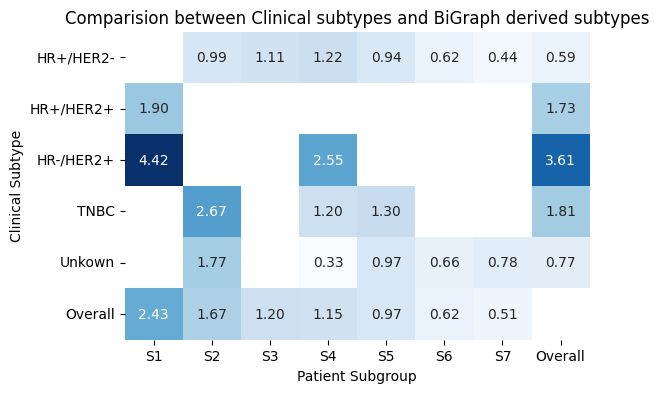

In [10]:
cph = CoxPHFitter()
Clinical_subtypes_ = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_]
DF = pd.DataFrame({'clinical_subtype' : ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan', 'Overall']})
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
        data = (np.array(Clinical_subtypes_) == clinical_subtype)*(np.array(Subgroup_ids_) == subgroup_id)
        if data.sum()>=5:
            cph.fit(pd.DataFrame({'Length': Length, 'Status': Status, 'flag': data}), 'Length', event_col='Status')
            DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'S'+str(int(subgroup_id))] = cph.hazard_ratios_[0]
        else:
            DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'S'+str(int(subgroup_id))] = np.nan

        
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    data = (np.array(Subgroup_ids_) == subgroup_id)
    if data.sum()>=5:
        length, status = Length_[data], Status_[data]
        cph.fit(pd.DataFrame({'Length': Length, 'Status': Status, 'flag': data}), 'Length', event_col='Status')
        DF.loc[DF['clinical_subtype'] =='Overall',  'S'+str(int(subgroup_id))] = cph.hazard_ratios_[0]
    else:
        DF.loc[DF['clinical_subtype'] =='Overall',  'S'+str(int(subgroup_id))] = np.nan

for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
    data = (np.array(Clinical_subtypes_) == clinical_subtype)
    if data.sum()>=5:
        cph.fit(pd.DataFrame({'Length': Length, 'Status': Status,'flag': data}), 'Length', event_col='Status')
        DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'Overall'] = cph.hazard_ratios_[0]
    else:
         DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'Overall'] = np.nan

# print(DF.values)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(DF.values[:,1:].astype('float'), ax=ax, cmap="Blues", annot=True, fmt=".2f", cbar = False)
ax.set_ylabel("Clinical Subtype")
ax.set_xlabel("Patient Subgroup")
ax.set_yticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'Unkown',  'Overall'], rotation=0)
ax.set_xticklabels(['S'+str(i) for i in range(1, int(np.max(Subgroup_ids_)+1))] + ['Overall'] ,rotation=0)
ax.set(title = "Comparision between Clinical subtypes and BiGraph derived subtypes")
plt.show()


### spearmanr_correlation

Clinical Subtype: HR+/HER2+, Subgroup: 1, correlation_coefficient: 0.51, p_val: 6.03e-27
Clinical Subtype: HR-/HER2+, Subgroup: 1, correlation_coefficient: 0.36, p_val: 6.36e-13
Clinical Subtype: TNBC, Subgroup: 2, correlation_coefficient: 0.23, p_val: 8.36e-06
Clinical Subtype: TNBC, Subgroup: 4, correlation_coefficient: 0.21, p_val: 5.80e-05
Clinical Subtype: HR+/HER2-, Subgroup: 1, correlation_coefficient: -0.28, p_val: 4.86e-08
Clinical Subtype: HR+/HER2-, Subgroup: 7, correlation_coefficient: 0.17, p_val: 6.66e-04


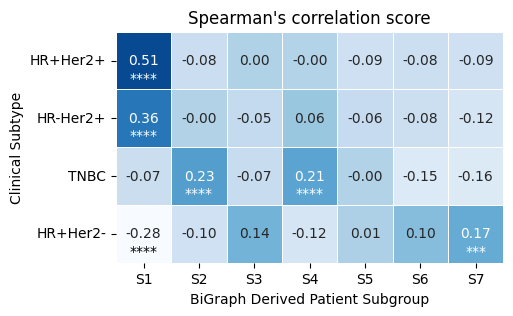

In [11]:
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr


spearmanr_corr = np.zeros((4, int(np.max(Subgroup_ids_))))
P_value = np.zeros((4, int(np.max(Subgroup_ids_))))
for clinical_subtype in ["HR+/HER2+", "HR-/HER2+", "TNBC", "HR+/HER2-"]:
    for subgroup_id in range(1, int(np.max(Subgroup_ids_) + 1)):
        variable_1 = (np.array(Clinical_subtypes_) == clinical_subtype) 
        variable_2 = (np.array(Subgroup_ids_) == subgroup_id)
        correlation_coefficient, p_value = spearmanr(variable_1, variable_2)
        spearmanr_corr[["HR+/HER2+", "HR-/HER2+", "TNBC", "HR+/HER2-"].index(clinical_subtype), subgroup_id-1] = correlation_coefficient
        P_value[["HR+/HER2+", "HR-/HER2+", "TNBC", "HR+/HER2-"].index(clinical_subtype), subgroup_id-1] = p_value
        if p_value < 0.05/(5*7):
            # print(0.05/35)
            # print(observed_data)
            # print(expected)
            print(
                    "Clinical Subtype: {}, Subgroup: {}, correlation_coefficient: {:.2f}, p_val: {:.2e}".format(
                        clinical_subtype, subgroup_id, correlation_coefficient, p_value
                    )
                )

       
f, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(spearmanr_corr, annot=True, fmt=".2f", cmap="Blues", cbar = False, linewidths=0.5, linecolor='white', ax=ax, vmax = 0.6)
ax.text(0 + 0.5, 0+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(0 + 0.5, 1+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(0 + 0.5, 3+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'black'
                 )

ax.text(1 + 0.5, 2+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(3 + 0.5, 2+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )

ax.text(6 + 0.5, 3+0.8 , '***',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
        # ax.text(x + 0.5, y+0.8 , '****',
        #          horizontalalignment='center',
        #          verticalalignment='center',
        #          )


ax.set_xlabel("BiGraph Derived Patient Subgroup")
ax.set_ylabel("Clinical Subtype")
ax.set_xticklabels(['S'+str(i) for i in range(1, int(np.max(Subgroup_ids_)+1))] ,rotation=0)
ax.set_yticklabels(["HR+Her2+", "HR-Her2+", "TNBC", "HR+Her2-"], rotation=0)
ax.set(title = "Spearman's correlation score")
plt.show()

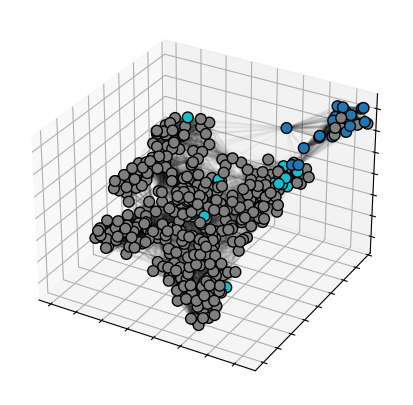

In [104]:
subgroup_id = 1
clinical_subtype = "HER2+"

color_palette_clinical = {
    'HR+/HER2+': sns.color_palette("Set3")[0],
    'HR-/HER2+': sns.color_palette("Set3")[4],
    'HER2+':sns.color_palette("tab10")[9],
    'TNBC': sns.color_palette("Set3")[5],
    'HR+/HER2-': sns.color_palette("Set3")[7],
}
color_palette_Bigraph = {
    1: sns.color_palette("tab10")[0],
    2: sns.color_palette("tab10")[1],
    3: sns.color_palette("tab10")[2],
    4: sns.color_palette("tab10")[3],
    5: sns.color_palette("tab10")[4],
    6: sns.color_palette("tab10")[5],
    7: sns.color_palette("tab10")[6],
}


Clinical_subtypes_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_])
Clinical_subtypes_[Clinical_subtypes_ == 'HR+/HER2+'] = 'HER2+'
Clinical_subtypes_[Clinical_subtypes_ == 'HR-/HER2+'] = 'HER2+'
G_population = construct_PopulationGraph(
    Gram_matrix,
    'two_step_knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
pos = nx.spring_layout(
    G_population, seed=3, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
)
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
edge_list = list(G_population.edges())
edge_alpha = [
    0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
    for u, v in edge_list
]

fig = plt.figure(figsize=(5,5), tight_layout=True)

Colors = []
for i in range(len(Patient_IDs_)):
    if Clinical_subtypes_[i] != clinical_subtype:
        Colors.append(sns.color_palette()[7])
    elif (Subgroup_ids_[i] == subgroup_id) & (Clinical_subtypes_[i] == clinical_subtype):
        Colors.append(color_palette_Bigraph[subgroup_id])
    elif (Subgroup_ids_[i] != subgroup_id) & (Clinical_subtypes_[i] == clinical_subtype):
        Colors.append(color_palette_clinical[clinical_subtype])
# Indices_included = np.where((Clinical_subtypes_ == clinical_subtype) + (Subgroup_ids_ == subgroup_id))[0]



ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    *node_xyz.T,
    s=60,
    c=Colors,
    edgecolors="black",
    linewidths=1,
    alpha=1
)

for i in range(len(edge_list)):
    u, v = edge_list[i]
    # if u in Indices_included and v in Indices_included:
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)

handles = [

    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette_Bigraph[subgroup_id],
        label=r'S{} \ {} (N = {})'.format(subgroup_id, clinical_subtype, np.sum((Clinical_subtypes_ != clinical_subtype) * (Subgroup_ids_ == subgroup_id))),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette_clinical[clinical_subtype],
        label=r'{} \ S{} (N = {})'.format(clinical_subtype, subgroup_id, np.sum((Clinical_subtypes_ == clinical_subtype) * (Subgroup_ids_ != subgroup_id))),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=sns.color_palette()[7],
        label=r'S{} $\cap$ {} (N = {})'.format(subgroup_id, clinical_subtype, np.sum((Clinical_subtypes_ == clinical_subtype) * (Subgroup_ids_ == subgroup_id))),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),

 
 ]
# ax.legend(handles=handles, fontsize = 10)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])

plt.show()

In [12]:
color_palette_clinical = {
    'HR+/HER2+': sns.color_palette("Set3")[0],
    'HR-/HER2+': sns.color_palette("Set3")[4],
    'HER2+':sns.color_palette("tab10")[9],
    'TNBC': sns.color_palette("Set3")[5],
    'HR+/HER2-': sns.color_palette("Set3")[7],
}
color_palette_Bigraph = {
    1: sns.color_palette("tab10")[0],
    2: sns.color_palette("tab10")[1],
    3: sns.color_palette("tab10")[2],
    4: sns.color_palette("tab10")[3],
    5: sns.color_palette("tab10")[4],
    6: sns.color_palette("tab10")[5],
    7: sns.color_palette("tab10")[6],
}

Clinical_subtypes_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_])
Clinical_subtypes_[Clinical_subtypes_ == 'HR+/HER2+'] = 'HER2+'
Clinical_subtypes_[Clinical_subtypes_ == 'HR-/HER2+'] = 'HER2+'

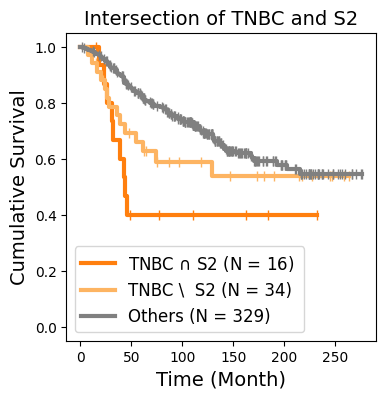

In [24]:
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()

clinical_subtype = "TNBC"
subgroup_id = 2


Indices_A = (Subgroup_ids_ == subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_A, event_observed_A = (
    Length_[Indices_A],
    Status_[Indices_A],
)
label = r"{} $\cap$ S{} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)


Indices_C = (Subgroup_ids_ != subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_C, event_observed_C = (
    Length_[Indices_C],
    Status_[Indices_C],
)
label = r"{} \  S{} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)


Indices_B = (
    (Clinical_subtypes_ != clinical_subtype)
)
length_B, event_observed_B = (
    Length_[Indices_B],
    Status_[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,
  
)


Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[((Clinical_subtypes_ == clinical_subtype)) & (Subgroup_ids_ == subgroup_id)] = 2
Groups_[((Clinical_subtypes_ == clinical_subtype)) & (Subgroup_ids_ != subgroup_id)] = 3

log_rank_test = multivariate_logrank_test(
    Length_,
    Groups_,
    Status_,
)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)

# ax.text(
#     0.3,
#     0.9,
#     s="p-value = {:.4f}".format(log_rank_test.p_value),
#     fontsize=14,
#     transform=ax.transAxes,
# )
ax.set_title("Intersection of {} and {}".format(clinical_subtype, 'S'+str(subgroup_id)), fontsize=14)
plt.show()

In [20]:
from lifelines.statistics import pairwise_logrank_test
log_rank_test = pairwise_logrank_test(
    Length_,
    Groups_,
    Status_,
)
log_rank_test.summary

test_statistic         p   -log2(p)
0 2       14.702734  0.000126  12.955849
  3        3.412484  0.064705   3.949979
2 3        0.600978  0.438205   1.190321

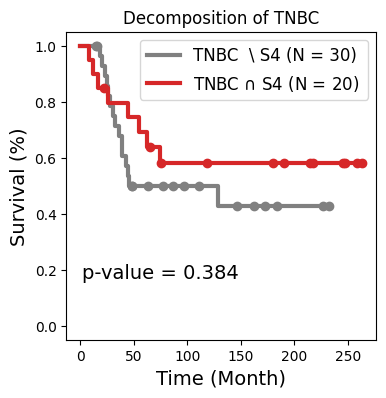

In [33]:
clinical_subtype = "TNBC"
subgroup_id = 4
Clinical_subtypes_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_])
Clinical_subtypes_[Clinical_subtypes_ == 'HR+/HER2+'] = 'HER2+'
Clinical_subtypes_[Clinical_subtypes_ == 'HR-/HER2+'] = 'HER2+'

f, ax = plt.subplots(figsize=(4, 4))
kmf = KaplanMeierFitter()


Indices_B = (Subgroup_ids_ != subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_B, event_observed_B = (
    Length_[Indices_B],
    Status_[Indices_B],
)
label = r"{}  \ S{} (N = {})".format(clinical_subtype, subgroup_id, len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 6, "marker": "o"},
    linewidth=3,
)

Indices_A = (Subgroup_ids_ == subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_A, event_observed_A = (
    Length_[Indices_A],
    Status_[Indices_A],
)
label = r"{} $\cap$ S{} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 6, "marker": "o"},
    markerfacecolor="grey",
    linewidth=3,
)


log_rank_test = logrank_test(length_A, length_B, event_observed_A, event_observed_B)

ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Survival (%)", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)

ax.text(
    0.05,
    0.2,
    s="p-value = {:.3f}".format(log_rank_test.p_value),
    fontsize=14,
    transform=ax.transAxes,
)
ax.set_title("Decomposition of {}".format(clinical_subtype))
plt.show()

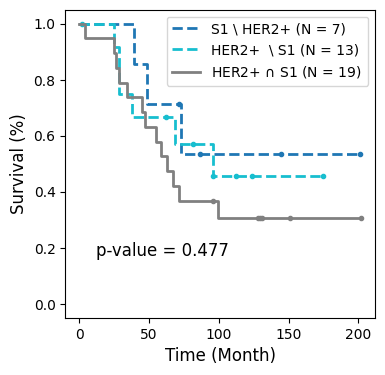

In [62]:
clinical_subtype = "HER2+"
subgroup_id = 1
f, ax = plt.subplots(figsize=(4, 4))
kmf = KaplanMeierFitter()
Indices_C = (Subgroup_ids_ == subgroup_id) & (Clinical_subtypes_ != clinical_subtype)
length_C, event_observed_C = (
    Length_[Indices_C],
    Status_[Indices_C],
)
label = r"S{} \ {} (N = {})".format(subgroup_id, clinical_subtype, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "o"},
    linestyle="--",
    linewidth=2,
)


Indices_B = (Subgroup_ids_ != subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_B, event_observed_B = (
    Length_[Indices_B],
    Status_[Indices_B],
)
label = r"{}  \ S{} (N = {})".format(clinical_subtype, subgroup_id, len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "o"},
    linestyle="--",
    linewidth=2,
)

Indices_A = (Subgroup_ids_ == subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_A, event_observed_A = (
    Length_[Indices_A],
    Status_[Indices_A],
)
label = r"{} $\cap$ S{} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 3, "marker": "o"},
    markerfacecolor="grey",
    linewidth=2,
)

Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[((Clinical_subtypes_ == clinical_subtype)) & (Subgroup_ids_ == subgroup_id)] = 1
Groups_[((Clinical_subtypes_ == clinical_subtype)) & (Subgroup_ids_ != subgroup_id)] = 2
Groups_[((Clinical_subtypes_ != clinical_subtype)) & (Subgroup_ids_ == subgroup_id)] = 3
log_rank_test = multivariate_logrank_test(Length_[Groups_!=0], Groups_[Groups_!=0], Status_[Groups_!=0])

ax.legend(fontsize=10)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
    ylim=(-0.05, 1.05),
)

ax.text(
    0.1,
    0.2,
    s="p-value = {:.3f}".format(log_rank_test.p_value),
    fontsize=12,
    transform=ax.transAxes,
)
plt.show()

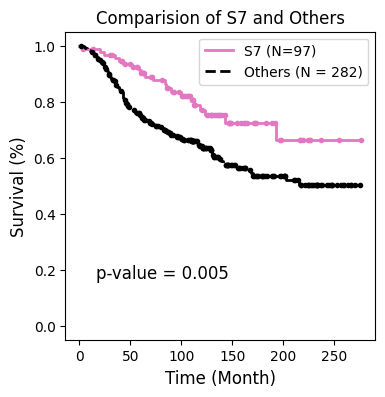

In [37]:
subgroup_id = 7
clinical_subtype = "HR+/HER2-"
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_C = (Subgroup_ids_ == subgroup_id) 
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'S{} (N={})'.format(subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette_Bigraph[subgroup_id],show_censors=True,censor_styles={"ms": 3, "marker": "o"},linewidth=2)



Indices_B = (Subgroup_ids_ != subgroup_id) 
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'Others (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linestyle = '--', linewidth=2)



Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[(Subgroup_ids_==subgroup_id)] = 1
Groups_[(Subgroup_ids_!=subgroup_id)] = 2
log_rank_test = multivariate_logrank_test(
        Length_,Groups_, Status_
    
)
ax.legend(fontsize = 10)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
ax.set(title = "Comparision of S{} and Others".format(subgroup_id))
ax.text(0.1,0.2, s = 'p-value = {:.3f}'.format(log_rank_test.p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

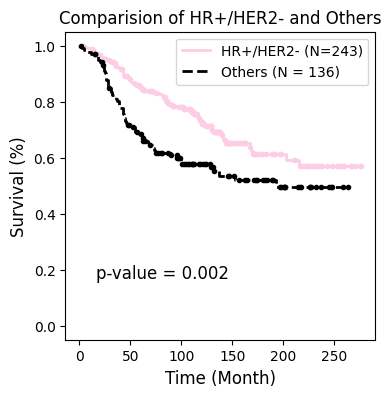

In [38]:

f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_C = (Clinical_subtypes_ == clinical_subtype) 
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'{} (N={})'.format(clinical_subtype, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette_clinical[clinical_subtype],show_censors=True,censor_styles={"ms": 3, "marker": "o"},linewidth=2)



Indices_B = (Clinical_subtypes_ != clinical_subtype) 
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'Others (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linestyle = '--', linewidth=2)



Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[(Clinical_subtypes_==clinical_subtype)] = 1
Groups_[(Clinical_subtypes_!=clinical_subtype)] = 2
log_rank_test = multivariate_logrank_test(
        Length_,Groups_, Status_
    
)
ax.legend(fontsize = 10)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
ax.set(title = "Comparision of {} and Others".format(clinical_subtype))
ax.text(0.1,0.2, s = 'p-value = {:.3f}'.format(log_rank_test.p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

### S1 & Her2+

In [25]:
Clinical_subtypes_ = np.array([clinical.loc[clinical['patient_id'] == i, 'Clinical Subtype'].values[0] for i in Patient_IDs_])
Patient_IDs_ = np.array(Patient_IDs_)
print("S1 and Her2+ patients:")
print(Patient_IDs_[(Subgroup_ids_ == 1) & ((Clinical_subtypes_ == 'HR-/HER2+') | (Clinical_subtypes_ == 'HR+/HER2+'))])

print("Her2+ patients && not S1:")
print(Patient_IDs_[(Subgroup_ids_ != 1) & ((Clinical_subtypes_ == 'HR-/HER2+') | (Clinical_subtypes_ == 'HR+/HER2+'))])

print("NOT Her2+ patients && S1:")
print(Patient_IDs_[(Subgroup_ids_ == 1) & ((Clinical_subtypes_ != 'HR-/HER2+') & (Clinical_subtypes_ != 'HR+/HER2+'))])

S1 and Her2+ patients:
[ 236  390  165  389  434  465  314  381 2513 3978 3361 3386  593  288
  130  371  479 3360 3435]
Her2+ patients && not S1:
[ 307  662  378  395  484 2742 3329 3528  148  152  201  120  388]
NOT Her2+ patients && S1:
[ 220  590  607 2844 3082  151  246]


#### Her2+ cell composition

(379, 32)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.360e-06 U_stat=0.000e+00


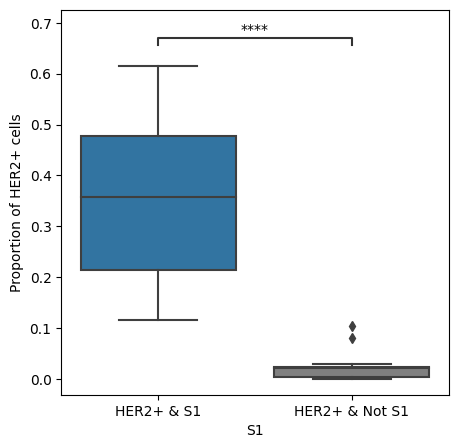

In [26]:
SoftWL_dict_0 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_0_" + node_label + ".pkl",
        ),
        "rb",
    ),
)
Histograms_0 = SoftWL_dict_0["Histogram"]
Histograms_0 = Histograms_0/np.sum(Histograms_0, axis=1, keepdims=True)
print(Histograms_0.shape)
DF = pd.DataFrame(
    {
        "Her2+": Histograms[
            (Clinical_subtypes_ == "HR-/HER2+") | (Clinical_subtypes_ == "HR+/HER2+"),
            16,
        ],
        'S1': Subgroup_ids_[(Clinical_subtypes_ == "HR-/HER2+") | (Clinical_subtypes_ == "HR+/HER2+") ] == 1
    }
).dropna()
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=DF, x="S1", y="Her2+", palette={
    True: sns.color_palette("tab10")[0],
    False: 'grey',
}, order=[True, False], ax = ax)
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [(True, False)],
            data=DF,
            x="S1",
            y="Her2+",
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(['HER2+ & S1', 'HER2+ & Not S1'])
ax.set_ylabel("Proportion of HER2+ cells")
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.231e-15 U_stat=1.915e+02
HR-/HER2+ vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.327e-09 U_stat=7.405e+02
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:7.083e-15 U_stat=2.235e+02
HR+/HER2+ vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:8.493e-10 U_stat=7.445e+02
HR-/HER2+ vs. nan: Mann-Whitney-Wilcoxon test two-sided, P_val:2.869e-08 U_stat=7.765e+02
HR+/HER2+ vs. nan: Mann-Whitney-Wilcoxon test two-sided, P_val:1.126e-08 U_stat=7.865e+02


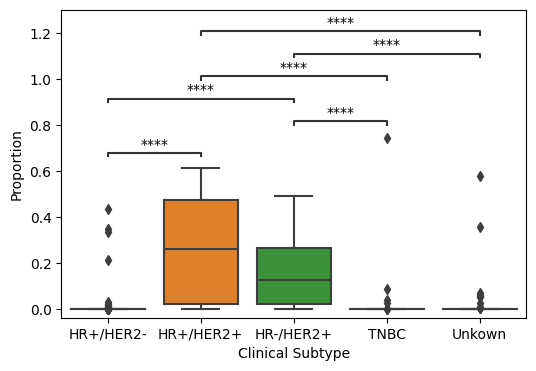

In [27]:
DF = pd.DataFrame(
    {
        "Proportion": Histograms[:, 16],
        'Clinical Subtype': Clinical_subtypes_
    }
).dropna()
f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=DF, x="Clinical Subtype", y="Proportion",  ax = ax, order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"])
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [("HR+/HER2-", "HR+/HER2+"), ("HR+/HER2-", "HR-/HER2+"), ("HR+/HER2+", "TNBC"), ("HR-/HER2+", "TNBC"), ("HR-/HER2+", "nan"), ("HR+/HER2+", "nan")],
            data=DF,
            x="Clinical Subtype",
            y="Proportion",
            order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"]
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "Unkown"])
# ax.set_xticklabels(['HER2+ & S1', 'HER2+ & Not S1'])
# ax.set_ylabel("Proportion of HER2+ cells")
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.148e-05 U_stat=3.166e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:3.303e-05 U_stat=3.138e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.893e-12 U_stat=9.850e+03
HR+/HER2- vs. nan: Mann-Whitney-Wilcoxon test two-sided, P_val:3.535e-02 U_stat=7.750e+03


[Text(0, 0, 'HR+/HER2-'),
 Text(1, 0, 'HR+/HER2+'),
 Text(2, 0, 'HR-/HER2+'),
 Text(3, 0, 'TNBC'),
 Text(4, 0, 'Unkown')]

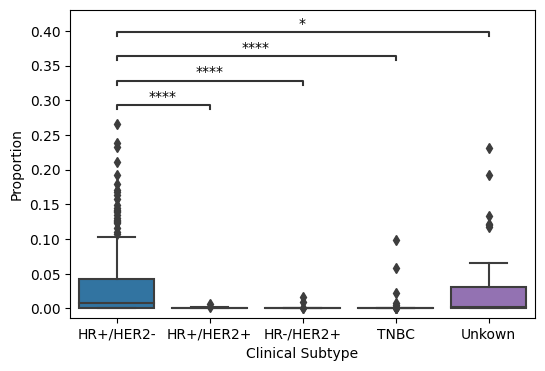

In [28]:
DF = pd.DataFrame(
    {
        "Proportion": Histograms[:, 12],
        'Clinical Subtype': Clinical_subtypes_
    }
).dropna()
f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=DF, x="Clinical Subtype", y="Proportion",  ax = ax, order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"])
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [("HR+/HER2-", "HR+/HER2+"), ("HR+/HER2-", "HR-/HER2+"), ("HR+/HER2-", "TNBC"), ("HR+/HER2-", "nan")],
            data=DF,
            x="Clinical Subtype",
            y="Proportion",
            order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"]
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "Unkown"])
# ax.set_xticklabels(['HER2+ & S1', 'HER2+ & Not S1'])
# ax.set_ylabel("Proportion of HER2+ cells")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR-/HER2+ vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.066e-01 U_stat=4.080e+02
TNBC vs. nan: Mann-Whitney-Wilcoxon test two-sided, P_val:1.436e-01 U_stat=1.558e+03
HR+/HER2+ vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.601e-02 U_stat=2.510e+02
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.136e-01 U_stat=5.654e+03


[Text(0, 0, 'HR+/HER2-'),
 Text(1, 0, 'HR+/HER2+'),
 Text(2, 0, 'HR-/HER2+'),
 Text(3, 0, 'TNBC'),
 Text(4, 0, 'Unkown')]

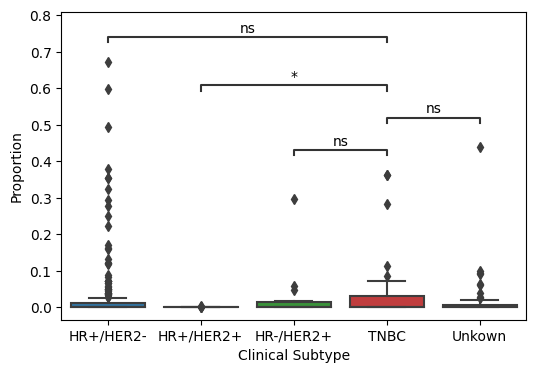

In [29]:
DF = pd.DataFrame(
    {
        "Proportion": Histograms[:, 10],
        'Clinical Subtype': Clinical_subtypes_
    }
).dropna()
f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=DF, x="Clinical Subtype", y="Proportion",  ax = ax, order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"])
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [("HR+/HER2-", "TNBC"), ("TNBC", "HR-/HER2+"), ("HR+/HER2+", "TNBC"), ("TNBC", "nan")],
            data=DF,
            x="Clinical Subtype",
            y="Proportion",
            order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"]
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "Unkown"])
# ax.set_xticklabels(['HER2+ & S1', 'HER2+ & Not S1'])
# ax.set_ylabel("Proportion of HER2+ cells")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR-/HER2+ vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.356e-02 U_stat=5.650e+02
TNBC vs. nan: Mann-Whitney-Wilcoxon test two-sided, P_val:5.506e-01 U_stat=1.442e+03
HR+/HER2+ vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.274e-01 U_stat=5.020e+02
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.115e-01 U_stat=5.717e+03


[Text(0, 0, 'HR+/HER2-'),
 Text(1, 0, 'HR+/HER2+'),
 Text(2, 0, 'HR-/HER2+'),
 Text(3, 0, 'TNBC'),
 Text(4, 0, 'Unkown')]

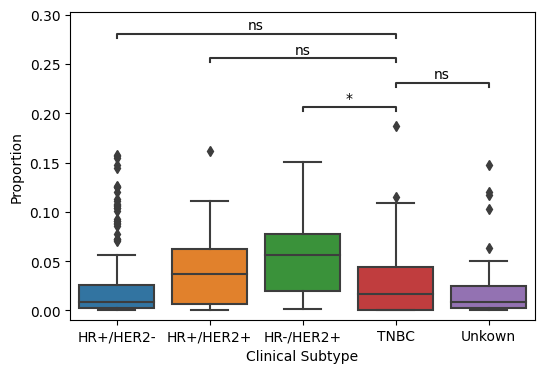

In [30]:
DF = pd.DataFrame(
    {
        "Proportion": Histograms[:, 11],
        'Clinical Subtype': Clinical_subtypes_
    }
).dropna()
f, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=DF, x="Clinical Subtype", y="Proportion",  ax = ax, order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"])
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [("HR+/HER2-", "TNBC"), ("TNBC", "HR-/HER2+"), ("HR+/HER2+", "TNBC"), ("TNBC", "nan")],
            data=DF,
            x="Clinical Subtype",
            y="Proportion",
            order = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"]
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "Unkown"])
# ax.set_xticklabels(['HER2+ & S1', 'HER2+ & Not S1'])
# ax.set_ylabel("Proportion of HER2+ cells")

#### Existence, instead of composition is correlated with prognosis

26
32
0.9147815739802547


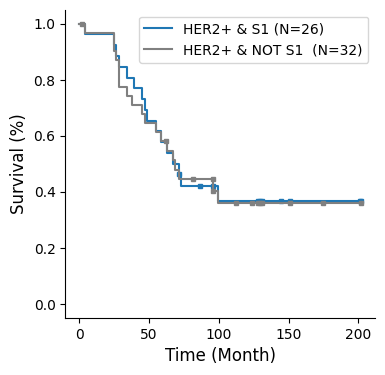

In [50]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(4,4))
Indices_A = (Subgroup_ids_ == 1) #& ((Clinical_subtypes_ == 'HR-/HER2+') | (Clinical_subtypes_ == 'HR+/HER2+'))
print(np.sum(Indices_A))
length_A, event_observed_A = (
            Length_[Indices_A],
            Status_[Indices_A],
        )
label = "HER2+ & S1 (N={})".format( len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_B =  ((Clinical_subtypes_ == 'HR-/HER2+') | (Clinical_subtypes_ == 'HR+/HER2+'))
print(np.sum(Indices_B))
length_B, event_observed_B = (
            Length_[Indices_B],
            Status_[Indices_B],
        )
label = "HER2+ & NOT S1  (N={})".format( len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# Indices_C = ((Clinical_subtypes_ != 'HR-/HER2+') & (Clinical_subtypes_ != 'HR+/HER2+'))
# length_C, event_observed_C = (
#             Length_[(Clinical_subtypes_ != 'HR-/HER2+') & (Clinical_subtypes_ != 'HR+/HER2+')],
#             Status_[(Clinical_subtypes_ != 'HR-/HER2+') & (Clinical_subtypes_ != 'HR+/HER2+')],
#         )
# label = "HER2- (N={})".format( len(length_C))
# kmf.fit(length_C, event_observed_C, label=label)
# kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
print(p_value)

# log_rank_test  = logrank_test(
#         Length_[Indices_C], Length_[Indices_B+ Indices_A],Status_[Indices_C], Status_[Indices_B+ Indices_A]
#     )
# p_value = log_rank_test.p_value
# print(p_value)



ax.legend(ncol=1, fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### S2 & TNBC

(379, 32)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.175e-02 U_stat=7.130e+03


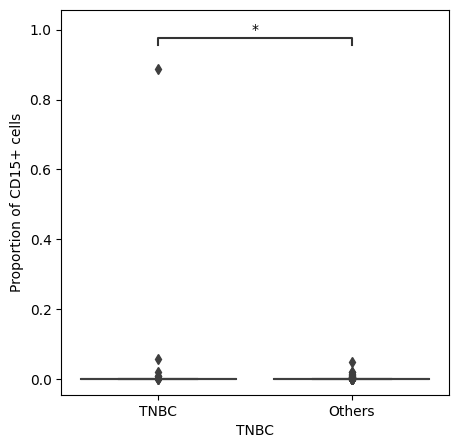

In [32]:
SoftWL_dict_0 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_0_" + node_label + ".pkl",
        ),
        "rb",
    ),
)
Histograms_0 = SoftWL_dict_0["Histogram"]
Histograms_0 = Histograms_0 / np.sum(Histograms_0, axis=1, keepdims=True)
print(Histograms_0.shape)
DF = pd.DataFrame(
    {
        "CD15+": Histograms_0[
            :,
            25,
        ],
        "TNBC": Clinical_subtypes_ == "TNBC",
    }
).dropna()
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    data=DF,
    x="TNBC",
    y="CD15+",
    palette={
        True: sns.color_palette("tab10")[0],
        False: "grey",
    },
    showfliers=True,
    order=[True, False],
    ax=ax,
)
from statannotations.Annotator import Annotator

annot = Annotator(
    ax,
    [(True, False)],
    data=DF,
    x="TNBC",
    y="CD15+",
)
annot.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="inside",
    verbose=2,
)
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(["TNBC", "Others"])
ax.set_ylabel("Proportion of CD15+ cells")
plt.show()

16
34
0.2601722336097412
0.009356757277566735


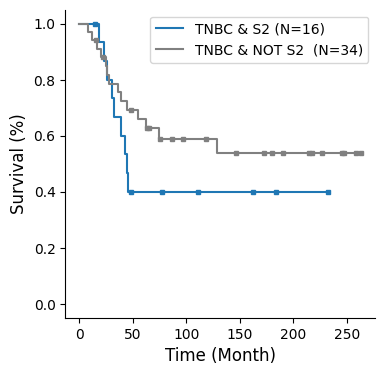

In [33]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(4,4))
Indices_A = (Subgroup_ids_ == 2) & ((Clinical_subtypes_ == 'TNBC') )
print(np.sum(Indices_A))
length_A, event_observed_A = (
            Length_[Indices_A],
            Status_[Indices_A],
        )
label = "TNBC & S2 (N={})".format( len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_B = (Subgroup_ids_ != 2) & ((Clinical_subtypes_ == 'TNBC') )
print(np.sum(Indices_B))
length_B, event_observed_B = (
            Length_[Indices_B],
            Status_[Indices_B],
        )
label = "TNBC & NOT S2  (N={})".format( len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_C = ((Clinical_subtypes_ != 'TNBC') )
length_C, event_observed_C = (
            Length_[Indices_C],
            Status_[Indices_C],
        )
label = "Not TNBC (N={})".format( len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
# kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
print(p_value)

log_rank_test  = logrank_test(
        Length_[Indices_C], Length_[Indices_B+ Indices_A],Status_[Indices_C], Status_[Indices_B+ Indices_A]
    )
p_value = log_rank_test.p_value
print(p_value)



ax.legend(ncol=1, fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### S7 and HR+/HER2-

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.852e-22 U_stat=1.484e+03


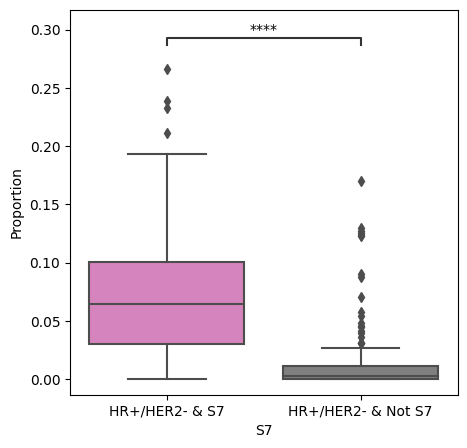

In [34]:
# Label = np.zeros_like(Clinical_subtypes_, dtype=int)
# Label[(Clinical_subtypes_ == "HR+/HER2-") & (Subgroup_ids_==7)] = 0
# Label[(Clinical_subtypes_ == "HR+/HER2-") & (Subgroup_ids_!=7)] = 1



DF = pd.DataFrame(
    {
        "Proportion": Histograms[
            Clinical_subtypes_ == "HR+/HER2-",
            12,
        ],
        'S7': Subgroup_ids_[Clinical_subtypes_ == "HR+/HER2-"] == 7
    }
).dropna()
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=DF, x="S7", y="Proportion", ax = ax, order = [True, False], palette={
    True: sns.color_palette("tab10")[6],
    False: 'grey',
})
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [(True, False)],
            data=DF,
            x="S7",
            y="Proportion",

        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(['HR+/HER2- & S7', 'HR+/HER2- & Not S7'])
ax.set_ylabel("Proportion")
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.439e-01 U_stat=7.089e+03


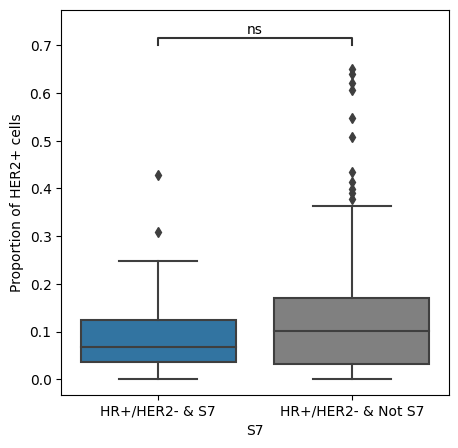

In [35]:
DF = pd.DataFrame(
    {
        "Proportion": Histograms_0[
            (Clinical_subtypes_ == "HR+/HER2-") ,
            0,
        ],
        'S7': Subgroup_ids_[(Clinical_subtypes_ == "HR+/HER2-") ] == 7
    }
).dropna()
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=DF, x="S7", y="Proportion", palette={
    True: sns.color_palette("tab10")[0],
    False: 'grey',
}, order=[True, False], ax = ax)
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [(True, False)],
            data=DF,
            x="S7",
            y="Proportion",
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(['HR+/HER2- & S7', 'HR+/HER2- & Not S7'])
ax.set_ylabel("Proportion of HER2+ cells")
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.067e-25 U_stat=1.078e+03


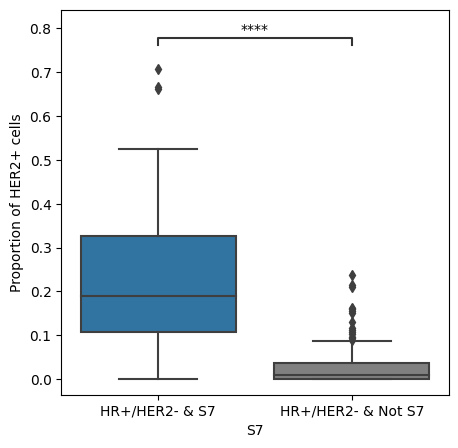

In [36]:
DF = pd.DataFrame(
    {
        "Proportion": Histograms_0[
            (Clinical_subtypes_ == "HR+/HER2-") ,
            9,
        ],
        'S7': Subgroup_ids_[(Clinical_subtypes_ == "HR+/HER2-") ] == 7
    }
).dropna()
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=DF, x="S7", y="Proportion", palette={
    True: sns.color_palette("tab10")[0],
    False: 'grey',
}, order=[True, False], ax = ax)
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [(True, False)],
            data=DF,
            x="S7",
            y="Proportion",
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(['HR+/HER2- & S7', 'HR+/HER2- & Not S7'])
ax.set_ylabel("Proportion of HER2+ cells")
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.706e-14 U_stat=2.516e+03


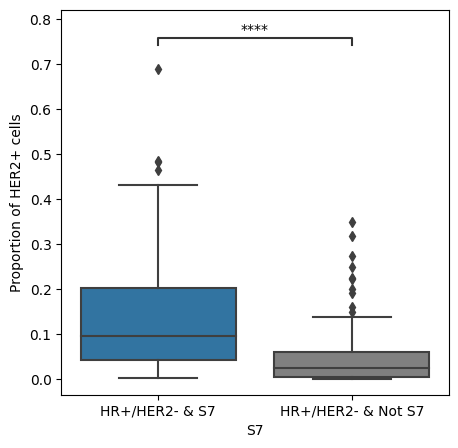

In [37]:
DF = pd.DataFrame(
    {
        "Proportion": Histograms_0[
            (Clinical_subtypes_ == "HR+/HER2-") ,
            10,
        ],
        'S7': Subgroup_ids_[(Clinical_subtypes_ == "HR+/HER2-") ] == 7
    }
).dropna()
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=DF, x="S7", y="Proportion", palette={
    True: sns.color_palette("tab10")[0],
    False: 'grey',
}, order=[True, False], ax = ax)
from statannotations.Annotator import Annotator
annot = Annotator(
            ax,
            [(True, False)],
            data=DF,
            x="S7",
            y="Proportion",
        )
annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
annot.apply_test()
ax, test_results = annot.annotate()
ax.set_xticklabels(['HR+/HER2- & S7', 'HR+/HER2- & Not S7'])
ax.set_ylabel("Proportion of HER2+ cells")
plt.show()

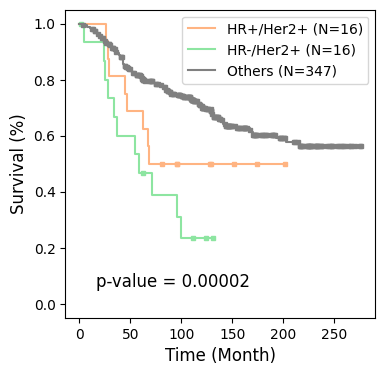

In [109]:
f, ax = plt.subplots(figsize=(4,4))
Indices_A = Clinical_subtypes_ == 'HR+/HER2+'
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = "HR+/Her2+ (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('pastel')[1],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_B = Clinical_subtypes_ == 'HR-/HER2+'
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = "HR-/Her2+ (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('pastel')[2],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_C = (Clinical_subtypes_ != 'HR-/HER2+') & (Clinical_subtypes_ != 'HR+/HER2+')
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = "Others (N={})".format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

ax.legend(fontsize = 10)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
Labels_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Labels_[(Clinical_subtypes_ == "HR+/HER2+")] = 1
Labels_[(Clinical_subtypes_ == "HR-/HER2+")] = 2
log_rank_test  = multivariate_logrank_test(
        Length_,Labels_, Status_
    )
p_value = log_rank_test.p_value
ax.text(0.1,0.1, s = 'p-value = {:.5f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

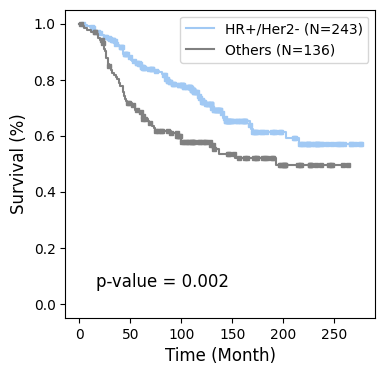

In [55]:
f, ax = plt.subplots(figsize=(4,4))
Indices_A = Clinical_subtypes_ == 'HR+/HER2-'
    
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = "HR+/Her2- (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('pastel')[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_B = Clinical_subtypes_ != 'HR+/HER2-'
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = "Others (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
ax.text(0.1,0.1, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

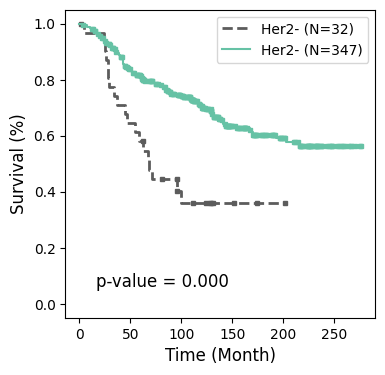

In [93]:
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (Clinical_subtypes_ == 'HR-/HER2+') + (Clinical_subtypes_ == 'HR+/HER2+')
    
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = "Her2- (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[4],show_censors=True,censor_styles={"ms": 3, "marker": "s"}, linewidth=2, linestyle='--')

Indices_B = (Clinical_subtypes_ != 'HR-/HER2+') * (Clinical_subtypes_ != 'HR+/HER2+')
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = "Her2- (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Set2')[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
ax.text(0.1,0.1, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

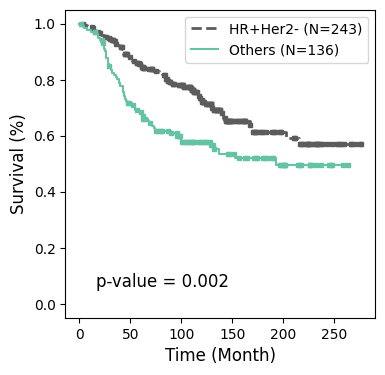

In [94]:
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = Clinical_subtypes_ == 'HR+/HER2-'
    
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = "HR+Her2- (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[4],show_censors=True,censor_styles={"ms": 3, "marker": "s"}, linewidth=2, linestyle='--')

Indices_B = Clinical_subtypes_ != 'HR+/HER2-'
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = "Others (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Set2')[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
ax.text(0.1,0.1, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

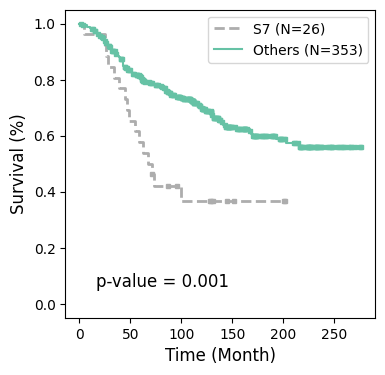

In [89]:
f, ax = plt.subplots(figsize=(4,4))
Indices_A = Subgroup_ids_ == 1
    
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = "S7 (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[2],show_censors=True,censor_styles={"ms": 3, "marker": "s"}, linewidth=2, linestyle='--')

Indices_B = Subgroup_ids_ != 1
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = "Others (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Set2')[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
ax.text(0.1,0.1, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

In [16]:
print(np.sum((Clinical_subtypes_ == 'TNBC')* (Subgroup_ids_ == 2)))
print(np.sum((Clinical_subtypes_ != 'TNBC')* (Subgroup_ids_ == 2)))
print(np.sum((Clinical_subtypes_ == 'TNBC')* (Subgroup_ids_ != 2)))
print(np.sum((Clinical_subtypes_ != 'TNBC')* (Subgroup_ids_ != 2)))

16
32
34
297


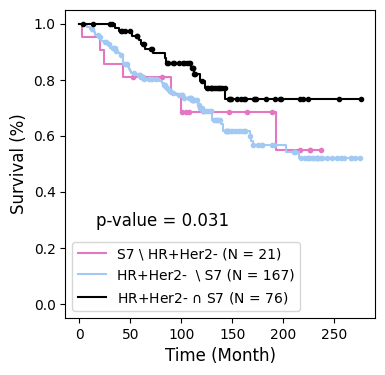

In [32]:
f, ax = plt.subplots(figsize=(4,4))

Indices_C = (Subgroup_ids_ == 7) & (Clinical_subtypes_ != 'HR+/HER2-')
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'S7 \ HR+Her2- (N = {})'.format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('tab10')[6],show_censors=True,censor_styles={"ms": 3, "marker": "o"})



Indices_B = (Subgroup_ids_ != 7) & (Clinical_subtypes_ == 'HR+/HER2-')
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'HR+Her2-  \ S7 (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('pastel')[0],show_censors=True,censor_styles={"ms": 3, "marker": "o"})

Indices_A = (Subgroup_ids_ == 7) & (Clinical_subtypes_ == 'HR+/HER2-')
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = r'HR+Her2- $\cap$ S7 (N = {}) '.format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"})


ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
ax.text(0.1,0.3, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

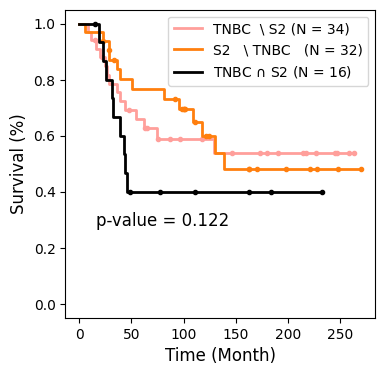

In [26]:
f, ax = plt.subplots(figsize=(4,4))

Indices_C = (Subgroup_ids_ != 2) & (Clinical_subtypes_ == 'TNBC')
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'TNBC  \ S2 (N = {})'.format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('pastel')[3],show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2)


Indices_B = (Subgroup_ids_ == 2) & (Clinical_subtypes_ != 'TNBC')
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'S2   \ TNBC   (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('tab10')[1],show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2)

Indices_A = (Subgroup_ids_ == 2) & (Clinical_subtypes_ == 'TNBC')
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = r'TNBC $\cap$ S2 (N = {}) '.format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2)

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
ax.text(0.1,0.3, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

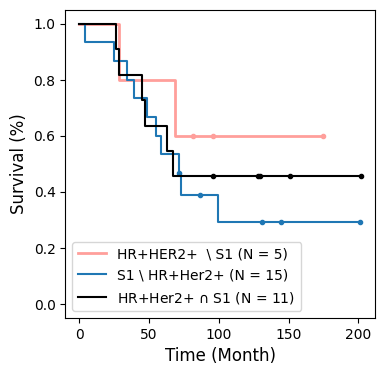

In [39]:
f, ax = plt.subplots(figsize=(4,4))

Indices_C = (Subgroup_ids_ != 1) & (Clinical_subtypes_ == 'HR+/HER2+')
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'HR+HER2+  \ S1 (N = {})'.format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('pastel')[3],show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2)




Indices_B = (Subgroup_ids_ == 1) & (Clinical_subtypes_ != 'HR+/HER2+')
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'S1 \ HR+Her2+ (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('tab10')[0],show_censors=True,censor_styles={"ms": 3, "marker": "o"})


Indices_A = (Subgroup_ids_ == 1) & (Clinical_subtypes_ == 'HR+/HER2+')
    
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = r'HR+Her2+ $\cap$ S1 (N = {}) '.format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"})

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
# log_rank_test  = logrank_test(
#         Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
#     )
# p_value = log_rank_test.p_value
# ax.text(0.5,0.8, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

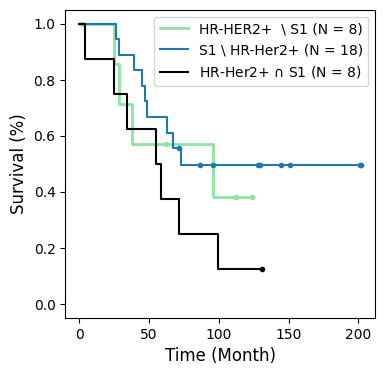

In [40]:
f, ax = plt.subplots(figsize=(4,4))

Indices_C = (Subgroup_ids_ != 1) & (Clinical_subtypes_ == 'HR-/HER2+')
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'HR-HER2+  \ S1 (N = {})'.format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('pastel')[2],show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2)




Indices_B = (Subgroup_ids_ == 1) & (Clinical_subtypes_ != 'HR-/HER2+')
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'S1 \ HR-Her2+ (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('tab10')[0],show_censors=True,censor_styles={"ms": 3, "marker": "o"})


Indices_A = (Subgroup_ids_ == 1) & (Clinical_subtypes_ == 'HR-/HER2+')
    
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = r'HR-Her2+ $\cap$ S1 (N = {}) '.format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"})

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
# log_rank_test  = logrank_test(
#         Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
#     )
# p_value = log_rank_test.p_value
# ax.text(0.5,0.8, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

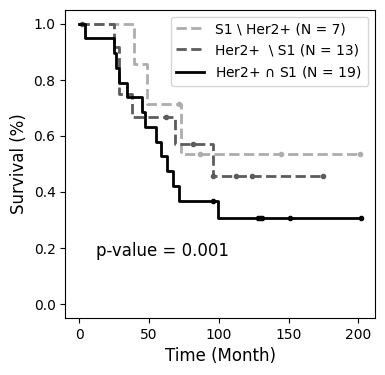

In [82]:
f, ax = plt.subplots(figsize=(4,4))

Indices_B = (Subgroup_ids_ == 1) & ((Clinical_subtypes_ != 'HR-/HER2+') & (Clinical_subtypes_ != 'HR+/HER2+')) 
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'S1 \ Her2+ (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[2],show_censors=True,censor_styles={"ms": 3, "marker": "o"},  linewidth = 2, linestyle = 'dashed')


Indices_C = (Subgroup_ids_ != 1) & ((Clinical_subtypes_ == 'HR-/HER2+') + (Clinical_subtypes_ == 'HR+/HER2+')) 
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'Her2+  \ S1 (N = {})'.format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[4],show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2, linestyle = 'dashed')


Indices_A = (Subgroup_ids_ == 1) & ((Clinical_subtypes_ == 'HR-/HER2+') + (Clinical_subtypes_ == 'HR+/HER2+')) 
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = r'Her2+ $\cap$ S1 (N = {}) '.format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"},  linewidth = 2, linestyle = 'solid')

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )

Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[((Clinical_subtypes_ == 'HR-/HER2+') + (Clinical_subtypes_ == 'HR+/HER2+')) & (Subgroup_ids_==1)] = 1
Groups_[((Clinical_subtypes_ == 'HR-/HER2+') + (Clinical_subtypes_ == 'HR+/HER2+')) & (Subgroup_ids_!=1)] = 2
Groups_[((Clinical_subtypes_ != 'HR-/HER2+') * (Clinical_subtypes_ != 'HR+/HER2+')) & (Subgroup_ids_==1)] = 3
log_rank_test = multivariate_logrank_test(
        Length_,Groups_, Status_
    
)
# log_rank_test  = logrank_test(
#         Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
#     )
p_value = log_rank_test.p_value
ax.text(0.1,0.2, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

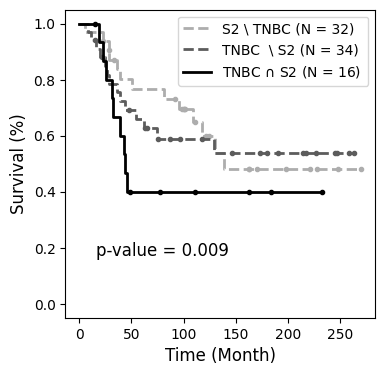

In [81]:
f, ax = plt.subplots(figsize=(4,4))

Indices_B = (Subgroup_ids_ == 2) & (Clinical_subtypes_ != 'TNBC')
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'S2 \ TNBC (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[2],show_censors=True,censor_styles={"ms": 3, "marker": "o"},  linewidth = 2, linestyle = 'dashed')


Indices_C = (Subgroup_ids_ != 2) & (Clinical_subtypes_ == 'TNBC')
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'TNBC  \ S2 (N = {})'.format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[4],show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2, linestyle = 'dashed')


Indices_A = (Subgroup_ids_ == 2) & (Clinical_subtypes_ == 'TNBC')
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = r'TNBC $\cap$ S2 (N = {}) '.format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"},  linewidth = 2, linestyle = 'solid')

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )

Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[(Clinical_subtypes_ == "TNBC") & (Subgroup_ids_==2)] = 1
Groups_[(Clinical_subtypes_ == "TNBC") & (Subgroup_ids_!=2)] = 2
Groups_[(Clinical_subtypes_ != "TNBC") & (Subgroup_ids_==2)] = 3
log_rank_test = multivariate_logrank_test(
        Length_,Groups_, Status_
    
)
# log_rank_test  = logrank_test(
#         Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
#     )
p_value = log_rank_test.p_value
ax.text(0.1,0.2, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

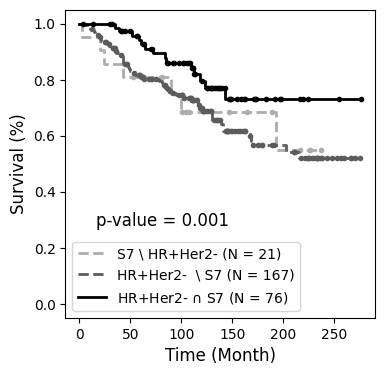

In [78]:
f, ax = plt.subplots(figsize=(4,4))

Indices_B = (Subgroup_ids_ == 7) & (Clinical_subtypes_ != 'HR+/HER2-')
length_B, event_observed_B = (
                Length_[Indices_B],
                Status_[Indices_B],
            )
label = r'S7 \ HR+Her2- (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[2],show_censors=True,censor_styles={"ms": 3, "marker": "o"},  linewidth = 2, linestyle = 'dashed')


Indices_C = (Subgroup_ids_ != 7) & (Clinical_subtypes_ == 'HR+/HER2-')
length_C, event_observed_C = (
                Length_[Indices_C],
                Status_[Indices_C],
            )
label = r'HR+Her2-  \ S7 (N = {})'.format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=sns.color_palette('Greys')[4],show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linewidth = 2, linestyle = 'dashed')


Indices_A = (Subgroup_ids_ == 7) & (Clinical_subtypes_ == 'HR+/HER2-')
length_A, event_observed_A = (
                Length_[Indices_A],
                Status_[Indices_A],
            )
label = r'HR+Her2- $\cap$ S7 (N = {}) '.format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"},  linewidth = 2, linestyle = 'solid')

ax.legend(fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )

Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[(Clinical_subtypes_ == "HR+/HER2-") & (Subgroup_ids_==7)] = 1
Groups_[(Clinical_subtypes_ == "HR+/HER2-") & (Subgroup_ids_!=7)] = 2
Groups_[(Clinical_subtypes_ != "HR-/HER2-") & (Subgroup_ids_==7)] = 3
log_rank_test = multivariate_logrank_test(
        Length_,Groups_, Status_
    
)
# log_rank_test  = logrank_test(
#         Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
#     )
p_value = log_rank_test.p_value
ax.text(0.1,0.3, s = 'p-value = {:.3f}'.format(p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

76
167
76
0.031414010309968175


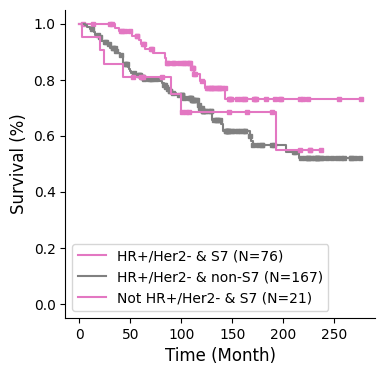

In [39]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(4,4))
Indices_A = (Subgroup_ids_ == 7) & ((Clinical_subtypes_ == 'HR+/HER2-') )
print(np.sum(Indices_A))
length_A, event_observed_A = (
            Length_[Indices_A],
            Status_[Indices_A],
        )
label = "HR+/Her2- & S7 (N={})".format( len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[6],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_B = (Subgroup_ids_ != 7) & ((Clinical_subtypes_ == 'HR+/HER2-') )
print(np.sum(Indices_B))
length_B, event_observed_B = (
            Length_[Indices_B],
            Status_[Indices_B],
        )
label = "HR+/Her2- & non-S7 (N={})".format( len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})


Indices_C = (Subgroup_ids_ == 7) & ((Clinical_subtypes_ != 'HR+/HER2-') )
print(np.sum(Indices_A))
length_C, event_observed_C = (
            Length_[Indices_C],
            Status_[Indices_C],
        )
label = "Not HR+/Her2- & S7 (N={})".format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[6],show_censors=True,censor_styles={"ms": 3, "marker": "s"})


log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
print(p_value)



ax.legend(ncol=1, fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

In [ ]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(4,4))
Indices_A = (Subgroup_ids_ == 4) & ((Clinical_subtypes_ == 'HR-/HER2+') )
print(np.sum(Indices_A))
length_A, event_observed_A = (
            Length_[Indices_A],
            Status_[Indices_A],
        )
label = "HR-/Her2+ & S4 (N={})".format( len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_B = (Subgroup_ids_ != 4) & ((Clinical_subtypes_ == 'HR-/HER2+') )
print(np.sum(Indices_B))
length_B, event_observed_B = (
            Length_[Indices_B],
            Status_[Indices_B],
        )
label = "HR-/Her2+ & NOT S4  (N={})".format( len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

Indices_C = ((Clinical_subtypes_ != 'TNBC') )
length_C, event_observed_C = (
            Length_[Indices_C],
            Status_[Indices_C],
        )
label = "Not TNBC (N={})".format( len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
# kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(
        Length_[Indices_A], Length_[Indices_B],Status_[Indices_A], Status_[Indices_B]
    )
p_value = log_rank_test.p_value
print(p_value)

log_rank_test  = logrank_test(
        Length_[Indices_C], Length_[Indices_B+ Indices_A],Status_[Indices_C], Status_[Indices_B+ Indices_A]
    )
p_value = log_rank_test.p_value
print(p_value)



ax.legend(ncol=1, fontsize = 10)
# ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### K-M Plot

In [ ]:
color_palette = sns.color_palette("tab10")
Length = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival (Months)"
        ].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
for clinical_subtype in ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']:
    for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
        try:
            f, ax = plt.subplots(figsize=(4, 4))
            length_B, event_observed_B = (
                    Length[
                        (np.array(Clinical_subtypes_) == clinical_subtype)  & (np.array(Subgroup_ids_) == subgroup_id) 
                    ],
                    Status[
                        (np.array(Clinical_subtypes_) == clinical_subtype) & (np.array(Subgroup_ids_) == subgroup_id) 
                    ],
                )
            label = "{} & S{} (N={})".format(clinical_subtype, subgroup_id, len(length_B))
            kmf.fit(length_B, event_observed_B, label=label)
            kmf.plot_survival_function(
                    ax=ax,
                    ci_show=False,
                    color=color_palette[subgroup_id-1],
                    show_censors=True,
                    censor_styles={"ms": 3, "marker": "s"},
                )
            
            length_A, event_observed_A = (
                    Length[
                        (np.array(Clinical_subtypes_) == clinical_subtype)  & (np.array(Subgroup_ids_) != subgroup_id) 
                    ],
                    Status[
                        (np.array(Clinical_subtypes_) == clinical_subtype) & (np.array(Subgroup_ids_) != subgroup_id) 
                    ],
                )
            label = "{} & Others (N={})".format(clinical_subtype, len(length_A))
            kmf.fit(length_A, event_observed_A, label=label)
            kmf.plot_survival_function(
                    ax=ax,
                    ci_show=False,
                    color='grey',
                    show_censors=True,
                    censor_styles={"ms": 3, "marker": "s"},
                )

            test = logrank_test(
                length_A,
                length_B,
                event_observed_A,
                event_observed_B,
                alpha=0.99,
                suppress_print=True,
            )
            p_value = test.p_value
            ax.set_title(
                "p = {:.3f}".format(p_value),
                fontsize=12,
            )
            
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
        except:
            pass

In [ ]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="TNBC"
subgroup_id = 7
f, ax = plt.subplots(figsize=(4, 4))
# histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (np.array(Clinical_subtype) == clinical_subtype)
  
        ],
        Status[
            (np.array(Clinical_subtype) == clinical_subtype)

        ],
    )
label = "{} (N={})".format(clinical_subtype, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )


length_B, event_observed_B = (
        Length[
            (np.array(Clinical_subtype) == clinical_subtype)
            & (Subgroup_ids_ == subgroup_id)
   
        ],
        Status[
            (np.array(Clinical_subtype) == clinical_subtype)
             & (Subgroup_ids_ == subgroup_id)
        ],
    )
label = "Positive (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B),
        np.concatenate([event_observed_A, event_observed_B]),
    )
p_value = log_rank_test.p_value
ax.legend(fontsize=10)
ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Subset 2

In [ ]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)

Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]  
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

In [ ]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from g_External_validation_random_split.Alignment import centroid_alignment_based_on_similarity
Gram_matrix_cohort2_ = get_Gram_matrix(Histograms_cohort2_)
Similarity_cohort2_discovery = get_Gram_matrix(np.concatenate([Histograms_cohort2_, Histograms_], axis=0))[:Histograms_cohort2_.shape[0], :][:, Histograms_cohort2_.shape[0]:]
assert Similarity_cohort2_discovery.shape[0] == Histograms_cohort2_.shape[0]
Subgroup_ids_cohort2_ = centroid_alignment_based_on_similarity(Similarity_cohort2_discovery, Subgroup_ids_)
print("{} patients are included".format(len(Patient_IDs_cohort2_)))

### Presentation in 4 clinical subtypes

In [ ]:

Clinical_subtype = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_cohort2_]

for subgroup_id in [1, 7]:
    DF_existence = pd.DataFrame({"Clinical Subtype": ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]})
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]:
        pattern_id = HR[subgroup_id-1]['community_id']
        data = (np.array(Clinical_subtype) == clinical_subtype)*(Subgroup_ids_cohort2_[:,subgroup_id-1] == 1)
        print(np.sum(data > 0))
        exisitence_ratio = np.sum(data > 0) / np.sum((np.array(Clinical_subtype) == clinical_subtype))
        DF_existence.loc[
            DF_existence["Clinical Subtype"] == clinical_subtype, "Existence (%)"
        ] = (exisitence_ratio * 100)
        # print(
        #     "Pattern {} in {} has {:.0f}% of patients".format(
        #         pattern_id, clinical_subtype, exisitence_ratio * 100
        #     )
        # )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
            x="Clinical Subtype",
            y="Existence (%)",
            data=DF_existence,
            order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
        )

In [ ]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival (Months)"
        ].values[0]
        for i in Patient_IDs_cohort2_
    ]
)
Status = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        for i in Patient_IDs_cohort2_
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype = "HR+/HER2+"
subgroup_id = 7
f, ax = plt.subplots(figsize=(4, 4))
length_B, event_observed_B = (
    Length[
        (np.array(Clinical_subtype) == "HR+/HER2-")* (Subgroup_ids_cohort2_[:,subgroup_id-1] == 1)
    ],
    Status[
        (np.array(Clinical_subtype) == "HR+/HER2-")* (Subgroup_ids_cohort2_[:,subgroup_id-1] == 1)
    ],
)
label = "HR+/HER2- (S7) (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=sns.color_palette("tab10")[6],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)

length_A, event_observed_A = (
    Length[
       (np.array(Clinical_subtype) == "HR+/HER2-")
        
    ],
    Status[
       (np.array(Clinical_subtype) == "HR+/HER2-")
   
    ],
)
label = "HR+/HER2- (Others) (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)


log_rank_test = multivariate_logrank_test(
    np.concatenate([length_A, length_B]),
    [0] * len(length_A) + [1] * len(length_B),
    np.concatenate([event_observed_A, event_observed_B]),
)
p_value = log_rank_test.p_value
ax.legend(fontsize=10)
ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

### K-M plot

In [ ]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival (Months)"
        ].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype = "HR+/HER2+"
subgroup_id = 1
f, ax = plt.subplots(figsize=(4, 4))
length_B, event_observed_B = (
    Length[
        ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+")) * (Subgroup_ids_ == subgroup_id)
    ],
    Status[
        ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+"))* (Subgroup_ids_ == subgroup_id)
    ],
)
label = "HR+/HER2- (S7) (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=sns.color_palette("tab10")[6],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)

length_A, event_observed_A = (
    Length[
       ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+"))
    ],
    Status[
       ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+"))
    ],
)
label = "HR+/HER2- (Others) (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)


log_rank_test = multivariate_logrank_test(
    np.concatenate([length_A, length_B]),
    [0] * len(length_A) + [1] * len(length_B),
    np.concatenate([event_observed_A, event_observed_B]),
)
p_value = log_rank_test.p_value
ax.legend(fontsize=10)
ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

# Jackson

### Clinical

In [ ]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical.head()
clinical.rename(columns={'ERStatus': 'ER Status'}, inplace=True)
clinical.rename(columns={'HER2Status': 'HER2 Status'}, inplace=True)
clinical.rename(columns={'PRStatus': 'PR Status'}, inplace=True)
clinical['ER Status'] = clinical['ER Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['HER2 Status'] = clinical['HER2 Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['PR Status'] = clinical['PR Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

### Histogram

In [ ]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

### Presentation in 4 clinical subtypes

In [ ]:

ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
print("{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(len(Clinical_subtype),
np.sum(Clinical_subtype == 'HR+/HER2-'), np.sum(Clinical_subtype == 'HR+/HER2+'), np.sum(Clinical_subtype == 'HR-/HER2+'), np.sum(Clinical_subtype == 'TNBC')))

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id-1]
    DF_presentation = pd.DataFrame({
        'Occurence': histogram,
        'Clinical Subtype': Clinical_subtype,
    })
    DF_presentation = DF_presentation.loc[DF_presentation['Clinical Subtype'] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x='Clinical Subtype', y='Occurence', data=DF_presentation, showfliers=True, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [("HR+/HER2-", "HR+/HER2+"), ("HR+/HER2-", "HR-/HER2+"), ("HR+/HER2-", "TNBC")],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    ax.set(ylabel = 'Proportion')

    DF_existence = pd.DataFrame({
        'Clinical Subtype': ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'],
    })
    for clinical_subtype in ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']:
        data = DF_presentation.loc[DF_presentation['Clinical Subtype'] == clinical_subtype, 'Occurence'].values
        
        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[DF_existence['Clinical Subtype'] == clinical_subtype, 'Existence (%)'] = exisitence_ratio*100
        print("Pattern {} in {} has {:.0f}% of patients".format(pattern_id, clinical_subtype, exisitence_ratio * 100))
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(x='Clinical Subtype', y='Existence (%)', data=DF_existence, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])

### K-M Plot

In [ ]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="HR+/HER2-"
f, ax = plt.subplots(figsize=(4, 4))
histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )



length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
      
        ],
        Status[
            (Clinical_subtype != clinical_subtype)

        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()